# Full train GRU standard(GRU4)

In [1]:
#!nvidia-smi

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

import math
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt

In [3]:
df_prices = pd.read_pickle("df_prices.pkl")
df_returns = pd.read_pickle("df_returns.pkl")
data = pd.read_pickle("data.pkl") 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1181900 entries, ('A', Timestamp('2014-09-17 00:00:00')) to ('^GSPC', Timestamp('2024-04-29 00:00:00'))
Data columns (total 29 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Dollar_Volume  1181900 non-null  float64
 1   RSI            1181900 non-null  float64
 2   BB_High        1181900 non-null  float64
 3   BB_Mid         1181900 non-null  float64
 4   BB_Low         1181900 non-null  float64
 5   ATR            1181900 non-null  float64
 6   NATR           1181900 non-null  float64
 7   MACD           1181900 non-null  float64
 8   Return_1d      1181900 non-null  float64
 9   Return_5d      1181900 non-null  float64
 10  Return_10d     1181900 non-null  float64
 11  Return_21d     1181900 non-null  float64
 12  Return_42d     1181900 non-null  float64
 13  Return_63d     1181900 non-null  float64
 14  High_Return    1181900 non-null  float64
 15  Low_Return     1181900 non

In [5]:
split_data = dict()

tscv = TimeSeriesSplit(n_splits=3)

for ticker in data.index.unique('Ticker'):
    X = data.loc[ticker].drop(columns=['target'])
    y = data.loc[ticker]['target']
    ticker_data = { 'X_train': [], 'X_test': [], 'y_train': [], 'y_test': [] }
    for train_index, test_index in tscv.split(data.loc[ticker]):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        ticker_data['X_train'].append(X_train)
        ticker_data['X_test'].append(X_test)
        ticker_data['y_train'].append(y_train)
        ticker_data['y_test'].append(y_test)

    split_data[ticker] = ticker_data

print(split_data.keys())
print(split_data['AAPL']["X_train"][0].shape, split_data['AAPL']["y_train"][0].shape,)

dict_keys(['A', 'AAL', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BG', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLDR', 'BLK', 'BMY', 'BR', 'BRO', 'BSX', 'BWA', 'BX', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CEG', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COR', 'COST', 'CPAY', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTLT', 'CTRA', 'CTSH', 'CTVA', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DAY', 'DD', 'DE', 'DECK', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS',

In [6]:
configs = {
    "batch_size" : 32,
    "max_file_count" : 2179,
    #"train_file" : 100,
    #"validation_file" : 5,
    #"test_file" : 1,
    "input_size" : 8,
    "output_size" : 1,
    "init_learning_rate" : 1e-4,
    "scheduler_factor": 0.5,
    "scheduler_patience": 2,
    "scheduler_min_lr": 3e-6,
    "epoch" : 5,
    "model_name" : "GRUFULL1",
}

#configs["file_count"] = configs["train_file"] + configs["validation_file"] + configs["test_file"]
configs["model_folder"] = f"./models/{configs["model_name"]}/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
torch.set_default_dtype(torch.float32)

class GRUBlock(nn.Module) :
    def __init__(self, input_size, output_size) :
        super().__init__()
        self.GRU = nn.GRU(input_size,output_size,1,batch_first=True,bias=True)
        self.Dropout = nn.Dropout(p=0.2)
        self.LayerNorm = nn.LayerNorm(output_size)
    
    def forward(self, input) :
        h1,_ = self.GRU(input)
        h2 = self.Dropout(h1)
        output = self.LayerNorm(h2)
        return output

class StockGRU(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.hidden_size = 64
        self.batch_size = configs["batch_size"]
        self.layer1 = GRUBlock(4,self.hidden_size)
        self.layer2 = GRUBlock(self.hidden_size,self.hidden_size)
        self.layer3 = nn.Linear(self.hidden_size,1,bias=True)

    def forward(self, input) :
        input = torch.multiply(input,25)
        h1 = self.layer1(input)
        h2 = self.layer2(h1)
        output = self.layer3(h2[:,-1,:])
        output = torch.multiply(output,0.04)
        return output

In [8]:
model = StockGRU()
model = model.to(device)

summary(model,input_size=(configs["batch_size"],configs["input_size"],4))

Layer (type:depth-idx)                   Param #
├─GRUBlock: 1-1                          --
|    └─GRU: 2-1                          13,440
|    └─Dropout: 2-2                      --
|    └─LayerNorm: 2-3                    128
├─GRUBlock: 1-2                          --
|    └─GRU: 2-4                          24,960
|    └─Dropout: 2-5                      --
|    └─LayerNorm: 2-6                    128
├─Linear: 1-3                            65
Total params: 38,721
Trainable params: 38,721
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─GRUBlock: 1-1                          --
|    └─GRU: 2-1                          13,440
|    └─Dropout: 2-2                      --
|    └─LayerNorm: 2-3                    128
├─GRUBlock: 1-2                          --
|    └─GRU: 2-4                          24,960
|    └─Dropout: 2-5                      --
|    └─LayerNorm: 2-6                    128
├─Linear: 1-3                            65
Total params: 38,721
Trainable params: 38,721
Non-trainable params: 0

In [9]:
loss_fn = torch.nn.L1Loss()

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr = configs["init_learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=configs['scheduler_factor'],
    patience=configs['scheduler_patience'],
    min_lr=configs['scheduler_min_lr']
)

In [11]:
class GRUdataset(Dataset) :
    def __init__(self, input_dataframe, output_dataframe, input_size = 1) :
        self.input_dataframe = input_dataframe
        self.output_dataframe = output_dataframe
        self.is_preprocessed = False
        self.input_size = input_size

    def Preprocess(self) :
        self.pre_input = []
        self.pre_output = []
        for i in range(self.__len__()) :
            input,output = self.__getitem__(i)
            self.pre_input.append(input)
            self.pre_output.append(output)
        self.is_preprocessed = True

    def __len__(self) :
        return len(self.input_dataframe) - self.input_size + 1
        
    def __getitem__(self, idx) :
        if(self.is_preprocessed) :
            return self.pre_input[idx],self.pre_output[idx]
    
        sub_iput_frame = self.input_dataframe.iloc[idx:idx + self.input_size]
        input_close = torch.tensor(sub_iput_frame["Return_1d"].values, dtype=torch.float32)
        input_open = torch.tensor(sub_iput_frame["Open_Return"].values, dtype=torch.float32)
        input_high = torch.tensor(sub_iput_frame["High_Return"], dtype=torch.float32)
        input_low = torch.tensor(sub_iput_frame["Low_Return"], dtype=torch.float32)

        output = torch.tensor(self.output_dataframe.iloc[idx + self.input_size - 1], dtype=torch.float32)

        return torch.stack((input_open,input_high,input_low,input_close)),output

In [12]:
train_losses = []
val_losses = []
avarage_train_losses = []
avarage_val_losses = []
learning_rates = []

model_folder = configs["model_folder"]
best_loss = 1000000

for epoch in tqdm(range(configs["epoch"])):

    cur_train_loss = []
    cur_val_loss = []

    for ticker in tqdm(data.index.unique('Ticker')):

        for iter in range(len(split_data[ticker]['X_train'])):
            # print("  Iter:", iter)
            X_train = split_data[ticker]['X_train'][iter]
            X_test = split_data[ticker]['X_test'][iter]
            y_train = split_data[ticker]['y_train'][iter]
            y_test = split_data[ticker]['y_test'][iter]

            train_data = GRUdataset(X_train, y_train,input_size=configs["input_size"])
            train_data.Preprocess()
            train_loader = torch.utils.data.DataLoader(train_data, batch_size=configs["batch_size"], shuffle=True)

            test_data = GRUdataset(X_test, y_test,input_size=configs["input_size"])
            test_data.Preprocess()
            test_loader = torch.utils.data.DataLoader(test_data, batch_size=configs["batch_size"], shuffle=False)

            model.to(device)
            model.train()

            total_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X = torch.transpose(batch_X[:,:,:],1,2).to(device)
                batch_y = batch_y[:,None].to(device)

                optimizer.zero_grad()
                
                y_pred = model(batch_X)

                loss = loss_fn(y_pred, batch_y)
                loss.backward()
                optimizer.step()

                train_losses.append(loss.to(torch.device("cpu")).item())
                cur_train_loss.append(loss.to(torch.device("cpu")).item())

            model.eval()

            with torch.no_grad():
                for batch_X, batch_y in test_loader:
                    batch_X = torch.transpose(batch_X[:,:,:],1,2).to(device)
                    batch_y = batch_y[:,None].to(device)
                    
                    y_pred = model(batch_X)

                    loss = loss_fn(y_pred, batch_y)

                    val_losses.append(loss.to(torch.device("cpu")).item())
                    cur_val_loss.append(loss.to(torch.device("cpu")).item())

    avarage_train_loss = np.mean(np.array(cur_train_loss))
    avarage_train_losses.append(avarage_train_loss)

    avarage_val_loss = np.mean(np.array(cur_val_loss))
    avarage_val_losses.append(avarage_val_loss)

    if(best_loss > avarage_val_loss) :

        state = {
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'train_loss': avarage_train_loss,
            'val_loss': avarage_val_loss,
            'best_val_loss': best_loss,
        }

        best_loss = avarage_val_loss

        torch.save(state, model_folder + "GRU.pth.tar")

    print("train loss : ",avarage_train_loss)
    print("val loss : ",avarage_val_loss)

    scheduler.step(avarage_val_loss)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\asus\AppData\Local\Temp\ipykernel_24536\2020453312.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  input_high = torch.tensor(sub_iput_frame["High_Return"], dtype=torch.float32)
C:\Users\asus\AppData\Local\Temp\ipykernel_24536\2020453312.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  input_low = torch.tensor(sub_iput_frame["Low_Return"], dtype=torch.float32)


train loss :  0.011826731127960474
val loss :  0.013205011799313118


  0%|          | 0/500 [00:00<?, ?it/s]

train loss :  0.011747670203409354
val loss :  0.01318998058487914


  0%|          | 0/500 [00:00<?, ?it/s]

train loss :  0.011688468357812226
val loss :  0.01312313419715658


  0%|          | 0/500 [00:00<?, ?it/s]

train loss :  0.011600077777224384
val loss :  0.013013994833604093


  0%|          | 0/500 [00:00<?, ?it/s]

train loss :  0.011531091998397143
val loss :  0.01295431889373792


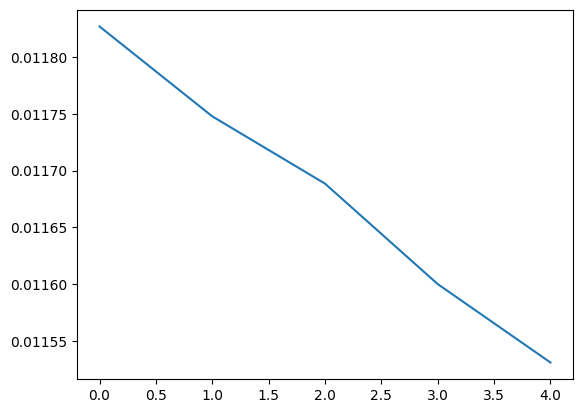

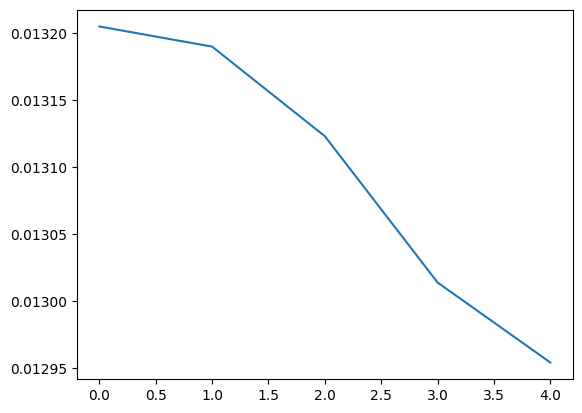

In [21]:
plt.plot(avarage_train_losses)
plt.show()
plt.plot(avarage_val_losses)
plt.show()

In [14]:
train_losses_file = open(configs["model_folder"] + "train_losses.txt",'w')
val_losses_file = open(configs["model_folder"] + "val_losses.txt","w")

for value in train_losses :
    train_losses_file.write(f"{value}\n")

for value in val_losses :
    val_losses_file.write(f"{value}\n")

train_losses_file.close()
val_losses_file.close()

In [15]:
best_model = StockGRU()
best_model.load_state_dict(torch.load(configs["model_folder"] + "GRU.pth.tar")['model'])

best_model.to(device)
best_model.eval()

StockGRU(
  (layer1): GRUBlock(
    (GRU): GRU(4, 64, batch_first=True)
    (Dropout): Dropout(p=0.2, inplace=False)
    (LayerNorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (layer2): GRUBlock(
    (GRU): GRU(64, 64, batch_first=True)
    (Dropout): Dropout(p=0.2, inplace=False)
    (LayerNorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (layer3): Linear(in_features=64, out_features=1, bias=True)
)

In [16]:
def get_log_stock_prediction(model, ticker) :
    model.eval()
    X_dataframe = data.loc[ticker].drop(columns=['target'])
    y_dataframe = data.loc[ticker]['target']

    dataset = GRUdataset(X_dataframe, y_dataframe, configs["input_size"])
    dataset.Preprocess()
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=configs["batch_size"], shuffle=False)

    predict_res = []
    target_res = []
    
    for batch_X, batch_y in dataloader:
        batch_X = torch.transpose(batch_X[:,:,:],1,2).to(device)
        batch_y = batch_y[:,None].to(device)
        
        y_pred = model(batch_X)

        predict_res += y_pred.to(torch.device("cpu")).reshape(-1).tolist()
        target_res += batch_y.to(torch.device("cpu")).reshape(-1).tolist()

    return np.array(predict_res),np.array(target_res)


In [17]:
def trade_test(predict, real) :
    buy_pos = predict > 0
    total_profit = np.exp(np.sum(buy_pos * real))
    return total_profit

In [18]:
def print_trade(best_model, stocks, output_frame) :
    for stock in tqdm(stocks) :
        predict,target = get_log_stock_prediction(best_model, [stock])
        buy_and_hold_profit = trade_test(np.ones(target.shape),target)
        naive_forecast_profit = trade_test(np.concatenate((np.array([0]),(target > 0)))[:-1],target)
        random_profit = trade_test(np.random.randint(low=0,high=2,size=target.shape),target)
        total_profit = trade_test(predict,target)
        inverse_total_profit = trade_test(-predict,target)
        
        new_row = {
            "Name": stock,
            "Buy_and_Hold" : buy_and_hold_profit,
            "Naive_Forecast" : naive_forecast_profit,
            "Random_Profit" : random_profit,
            "Total_Profit" : total_profit,
            "Inverse_Total_Profit" : inverse_total_profit
        }
        
        output_frame.loc[len(output_frame.index)] = new_row

In [19]:
test_filenames = data.index.unique('Ticker').to_list()
output_frame = pd.DataFrame(columns=["Name","Buy_and_Hold","Naive_Forecast","Random_Profit","Total_Profit","Inverse_Total_Profit"])
print_trade(best_model,test_filenames,output_frame)
output_frame.to_csv("./out/" + configs["model_name"] + "out.csv",index = False)

  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\asus\AppData\Local\Temp\ipykernel_24536\2020453312.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  input_high = torch.tensor(sub_iput_frame["High_Return"], dtype=torch.float32)
C:\Users\asus\AppData\Local\Temp\ipykernel_24536\2020453312.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  input_low = torch.tensor(sub_iput_frame["Low_Return"], dtype=torch.float32)
C:\Users\asus\AppData\Local\Temp\ipykernel_24536\2020453312.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavio

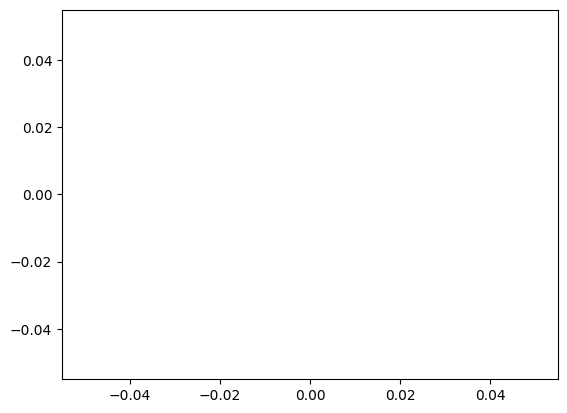

In [20]:
plt.plot(learning_rates)
plt.show()